<a href="https://colab.research.google.com/github/Lutris98/PersonalProject_TradingBot/blob/main/2.Visualization/Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install beautifulsoup4 
!pip install requests
!pip install mplfinance

In [17]:
from bs4 import BeautifulSoup 
import requests 

In [18]:
url='https://finance.naver.com/item/sise_day.nhn?code=066570'
headers = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.150 Safari/537.36'}
lgresponse=requests.get(url, headers = headers).text

In [19]:
html=BeautifulSoup(lgresponse,'lxml') 
pgrr=html.find('td',class_='pgRR')
s=str(pgrr.a['href']).split('=')
last_page=s[-1] 

In [20]:
import pandas as pd #실제 스크레이핑엔 requests로 만든 response객체를 read_html해서 읽어옴(beautifulsoup는 찾기만)
lg_df=pd.DataFrame()
for page in range(1, int(last_page)+1): 
  page_url='{0}&page={1}'.format(url,page) 
  lgresponse=requests.get(page_url, headers = headers).text
  lg_df=lg_df.append(pd.read_html(lgresponse,header=0)[0]) 
lg_df=lg_df.dropna()
lg_df=lg_df.rename(columns={'날짜':'Date','시가':'Open','고가':'High','저가':'Low','종가':'Close','거래량':'Volume'}) #mpf에 맞게 OHLCV만 남기고 지움(날짜는 잠시 살려둠)
lg_df.index=pd.to_datetime(lg_df['Date']) #모든 분석에서 index가 datetime형식이어야함
lg_df=lg_df[['Open','High','Low','Close','Volume']]  
lg_df.sort_index(ascending=True,inplace=True) #추후분석에서는 아래가 높게 #value가 아니라 인덱스임

#1.차트분석

##1)캔들차트

In [21]:
candle_df=lg_df.iloc[-30:-1] #candle은 기간너무 길게 잡으면 가시성이 떨어지니깐 
candle_df.sort_index(ascending=False,inplace=True) #candle은 위가 높게

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


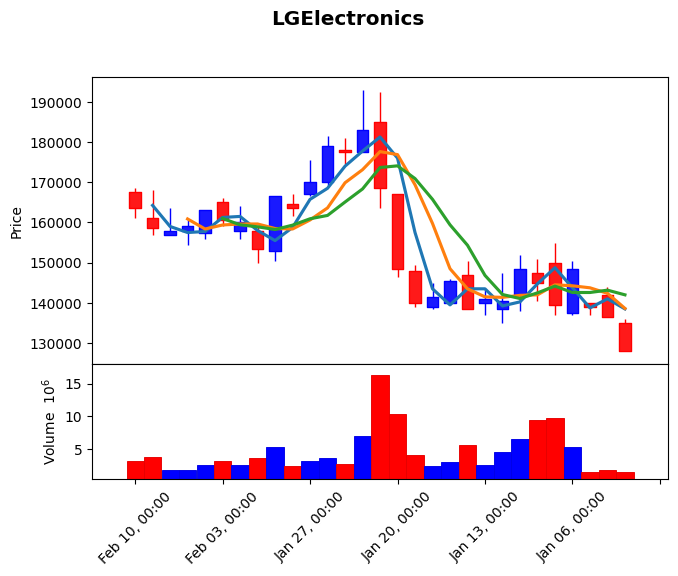

In [22]:
import mplfinance as mpf
kwargs=dict(type='candle',mav=(2,4,6),volume=True,title='LGElectronics',ylabel='Price') #한국어 지원 안됨ㅠ
mc=mpf.make_marketcolors(up='r',down='b',inherit=True) 
s=mpf.make_mpf_style(marketcolors=mc)
mpf.plot(candle_df,**kwargs,style=s)

##2)누적 일간변동률(cumulative DPC) 차트

In [23]:
url='https://finance.naver.com/item/sise_day.nhn?code=005930'
smresponse=requests.get(url, headers = headers).text
html=BeautifulSoup(smresponse,'lxml') 
pgrr=html.find('td',class_='pgRR')
s=str(pgrr.a['href']).split('=')
last_page=s[-1] 
import pandas as pd
sm_df=pd.DataFrame()
for page in range(1, int(last_page)+1): 
  page_url='{0}&page={1}'.format(url,page) 
  smresponse=requests.get(page_url, headers = headers).text
  sm_df=sm_df.append(pd.read_html(smresponse,header=0)[0]) 
sm_df=sm_df.dropna()

In [24]:
sm_df=sm_df.rename(columns={'날짜':'Date','시가':'Open','고가':'High','저가':'Low','종가':'Close','거래량':'Volume'}) 
sm_df.index=pd.to_datetime(sm_df['Date']) 
sm_df=sm_df[['Open','High','Low','Close','Volume']]  
sm_df.sort_index(inplace=True) #아래가 높음 #inplace필수

In [25]:
lg_df=lg_df.iloc[-250:-1] #연중 평일은 250일 정도 #행기준 인덱싱은 쉼표필요없음
lg_dpc=(lg_df['Close']/lg_df['Close'].shift(1)-1)*100 #당연히 어제것을 많이 쓰니깐(특정 인덱스기준 값이 아래로 간다)
lg_dpc.iloc[0]=0 #이제 인덱스만으로 못쓰니깐 #초깃값 일치
lg_dpc_cs=lg_dpc.cumsum()
sm_df=sm_df.iloc[-250:-1]
sm_dpc=(sm_df['Close']/sm_df['Close'].shift(1)-1)*100
sm_dpc.iloc[0]=0
sm_dpc_cs=sm_dpc.cumsum()

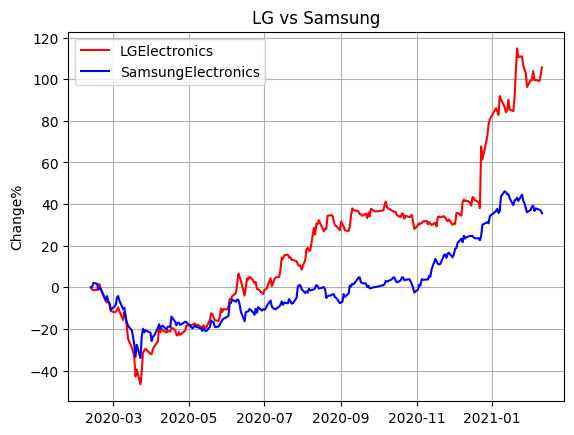

In [26]:
import matplotlib.pyplot as plt
plt.plot(lg_df.index,lg_dpc_cs,'r',label='LGElectronics') #색과 레이블명까지
plt.plot(sm_df.index,sm_dpc_cs,'b',label='SamsungElectronics')
plt.title('LG vs Samsung')
plt.ylabel('Change%')
plt.legend(loc='best') #이 두개는 그냥 기본 값
plt.grid(True)

##3)최대손실폭(max Drawdown) 차트

In [27]:
peak=lg_df['Close'].rolling(30,min_periods=1).max() #3개 다 series형식
dd=lg_df['Close']/peak
maxdd=dd.rolling(30,min_periods=1).min()

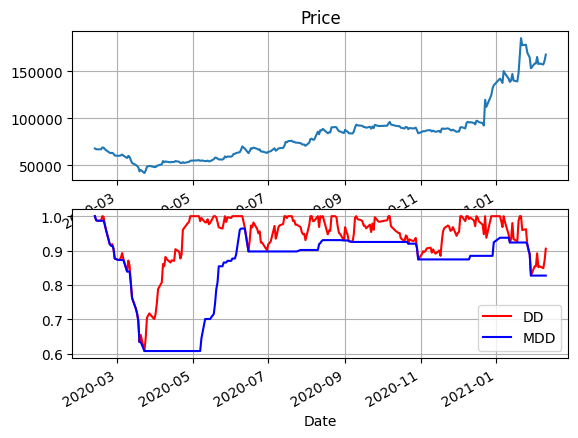

In [28]:
plt.subplot(2,1,1) #훨씬 편함
lg_df.Close.plot(title='Price',grid=True)
plt.subplot(2,1,2)
dd.plot(c='red',label='DD',grid=True,legend=True)
maxdd.plot(c='blue',label='MDD',grid=True,legend=True)
plt.show()

#2.트레이딩 전략 구현<br>

##1)샤프지수(효율적 포트폴리오)




##2)볼린저밴드(추세추종,반전매매)

##3)삼중창매매<br>
MarketTide,MarketWave,EntryTechnique

##4)듀얼모멘텀